# Microbiome Data Analysis

This notebook contains the end-to-end microbiome analysis

In [56]:
pip install pandas scikit-bio biom-format

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
from skbio import TreeNode
from skbio.diversity import alpha_diversity
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from skbio.stats.composition import multiplicative_replacement
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-bio


In [3]:
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### 1. Data Loading and Initial Merging

In [58]:
import pandas as pd

# Load the datasets
lung_baseline_df = pd.read_excel('content/Lung Baseline.xlsx')
lung_middle_df = pd.read_excel('content/Lung Middle.xlsx')
lung_late_df = pd.read_excel('content/Lung Late.xlsx')

print("lung baseline shape: ", lung_baseline_df.shape)
print("lung middle shape: ", lung_middle_df.shape)
print("lung late shape: ", lung_late_df.shape)
print(30*'*')


matrix_lung_base_df = pd.read_excel('content/Matrix Lung Base.xlsx')
matrix_lung_middle_df = pd.read_excel('content/Matrix Lung Middle.xlsx')
matrix_lung_late_df = pd.read_excel('content/Matrix Lung Late.xlsx')

print("Matrix lung base shape: ", matrix_lung_base_df.shape)
print("Matrix lung middle shape: ", matrix_lung_middle_df.shape)
print("Matrix lung late shape: ", matrix_lung_late_df.shape)
print(30*'*')


meta_lung_base_df = pd.read_excel('content/Meta Lung Base.xlsx')
meta_lung_middle_df = pd.read_excel('content/Meta Lung Middle.xlsx')
meta_lung_late_df = pd.read_excel('content/Meta Lung Late.xlsx')

print("Meta lung base shape: ", meta_lung_base_df.shape)
print("Meta lung middle shape: ", meta_lung_middle_df.shape)
print("Meta lung late shape: ", meta_lung_late_df.shape)


lung baseline shape:  (590, 604)
lung middle shape:  (159, 604)
lung late shape:  (49, 604)
******************************
Matrix lung base shape:  (590, 1461)
Matrix lung middle shape:  (159, 1461)
Matrix lung late shape:  (49, 1461)
******************************
Meta lung base shape:  (600, 21)
Meta lung middle shape:  (164, 21)
Meta lung late shape:  (51, 21)


In [59]:
lung_df = pd.concat([lung_baseline_df,lung_middle_df, lung_late_df])
matrix_lung_df = pd.concat([matrix_lung_base_df, matrix_lung_middle_df, matrix_lung_late_df])
meta_lung_df = pd.concat([meta_lung_base_df, meta_lung_middle_df, meta_lung_late_df])

lung_df.shape, matrix_lung_df.shape, meta_lung_df.shape

((798, 604), (798, 1461), (815, 21))

In [60]:
# Get columns of each dataset
taxa_columns = matrix_lung_df.columns.tolist()
meta_columns = meta_lung_df.columns.tolist()
data_columns = lung_df.columns.tolist()

# Store the columns in lists
taxa_columns_list = list(taxa_columns)
meta_columns_list = list(meta_columns)
data_columns_list = list(data_columns)

# Print the columns
print("Columns in lung_base_taxa:", taxa_columns_list)
print("Columns in lung_base_meta:", meta_columns_list)
print("Columns in lung_base_data:", data_columns_list)

Columns in lung_base_taxa: ['sample_id', 'total', 'Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Nitrososphaeraceae_ge', 'Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter', 'Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanosphaera', 'Archaea;Halobacterota;Halobacteria;Halobacterales;Halococcaceae;Halalkalicoccus', 'Archaea;Halobacterota;Halobacteria;Halobacterales;Halococcaceae;Halococcus', 'Archaea;Halobacterota;Halobacteria;Halobacterales;Halomicrobiaceae;Halomicrobium', 'Archaea;Nanoarchaeota;Nanoarchaeia;Woesearchaeales;GW2011_GWC1_47_15;GW2011_GWC1_47_15_ge', 'Archaea;Nanoarchaeota;Nanoarchaeia;Woesearchaeales;SCGC_AAA011_D5;SCGC_AAA011_D5_ge', 'Archaea;Thermoplasmatota;Thermoplasmata;Methanomassiliicoccales;Methanomassiliicoccaceae;Methanomassiliicoccus', 'Archaea;Thermoplasmatota;Thermoplasmata;Methanomassiliicoccales;Methanomethylophilaceae;Candidatus_Methanomethylophi

In [61]:
# Merge datasets on 'sample_id'
merged_metadata_df = pd.merge(lung_df, meta_lung_df, on='sample_id', suffixes=('_baseline', '_meta'))
merged_data = pd.merge(merged_metadata_df, matrix_lung_df, on='sample_id')

# Check for missing values and general data inspection
missing_values = merged_data.isnull().sum()
merged_data.head(), missing_values

(  SubjectIDDay_baseline                 sample_id  ...1.x  \
 0                4336_1           0102.4336.1.ETA    1331   
 1                3987_1             0102.3987.1.T    1057   
 2                4678_1   0102.4678.D01.ETA.Undep    2095   
 3                4636_1     0102.4636.1.UNDEP.ETA    2003   
 4                4866_1  0102.4866.1.20200130.ETA    2578   
 
   SampleID_Merge_baseline  N_baseline  total16sreads_baseline  \
 0        4336_1_ETA_Undep         893                   10000   
 1        3987_1_ETA_Undep         613                    9996   
 2        4678_1_ETA_Undep        1617                    4453   
 3        4636_1_ETA_Undep        1526                    9993   
 4        4866_1_ETA_Undep        1965                    5941   
 
    StudyNumber_baseline StudyName_baseline  SubjectID.x  Day.x  ...  \
 0                   102               alir         4336      1  ...   
 1                   102               alir         3987      1  ...   
 2          

In [62]:
import pandas as pd

# Analyzing missing values
missing_values_summary = merged_data.isnull().sum()
missing_percentage = (missing_values_summary / len(merged_data)) * 100

# Combine count and percentage of missing values
missing_data_info = pd.DataFrame({'Missing Values': missing_values_summary, 'Percentage (%)': missing_percentage})
print("Missing data summary:")
print(missing_data_info[missing_data_info['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False))



Missing data summary:
                           Missing Values  Percentage (%)
SeedsAlirOverlap_baseline             815      100.000000
DateofStartAC                         815      100.000000
Proning                               815      100.000000
cta_completed                         815      100.000000
CTADate                               815      100.000000
...                                   ...             ...
LabVitalsVentID                         2        0.245399
BilateralInfiltrate                     2        0.245399
SampleDay                               2        0.245399
StudyDay                                2        0.245399
PlateauPressureMeasured                 2        0.245399

[594 rows x 2 columns]


In [63]:
# Identify columns with more than 50% missing values
columns_to_drop = missing_data_info[missing_data_info['Percentage (%)'] > 50].index

# Drop these columns from the dataset
merged_data_cleaned = merged_data.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns with more than 50% missing values.")
print("Shape after dropping columns:", merged_data_cleaned.shape)


Dropped 333 columns with more than 50% missing values.
Shape after dropping columns: (815, 1751)


In [64]:
import numpy as np

# Replace infinity values with NaN for numerical columns
merged_data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any remaining infinity values
inf_values = (merged_data_cleaned == np.inf).sum().sum() + (merged_data_cleaned == -np.inf).sum().sum()
print(f"Number of infinity values remaining: {inf_values}")


Number of infinity values remaining: 0


In [65]:
from sklearn.impute import SimpleImputer

# Separate numerical and categorical columns again to ensure they are defined correctly
numerical_cols = merged_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = merged_data_cleaned.select_dtypes(include=['object']).columns


In [66]:
# Convert all categorical columns to strings to ensure consistent data types
for col in categorical_cols:
    merged_data_cleaned[col] = merged_data_cleaned[col].astype(str)

# Re-attempt to impute missing values for categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
merged_data_cleaned[categorical_cols] = categorical_imputer.fit_transform(merged_data_cleaned[categorical_cols])

# Verify the remaining missing values in categorical columns
remaining_categorical_missing = merged_data_cleaned[categorical_cols].isnull().sum().sum()
print(f"Number of remaining missing values in categorical columns: {remaining_categorical_missing}")

Number of remaining missing values in categorical columns: 0


In [67]:
# Impute missing values for numerical columns with median
numerical_imputer = SimpleImputer(strategy='median')
merged_data_cleaned[numerical_cols] = numerical_imputer.fit_transform(merged_data_cleaned[numerical_cols])

# Verify the remaining missing values in numerical columns
remaining_numerical_missing = merged_data_cleaned[numerical_cols].isnull().sum().sum()
print(f"Number of remaining missing values in numerical columns: {remaining_numerical_missing}")

# Final check of missing values in the entire dataset
remaining_missing_values = merged_data_cleaned.isnull().sum().sum()
print(f"Total number of remaining missing values in the entire dataset: {remaining_missing_values}")

# Check the cleaned dataset
print("Dataset after handling missing values:")
print(merged_data_cleaned.head())


Number of remaining missing values in numerical columns: 0
Total number of remaining missing values in the entire dataset: 0
Dataset after handling missing values:
  SubjectIDDay_baseline                 sample_id  ...1.x  \
0                4336_1           0102.4336.1.ETA  1331.0   
1                3987_1             0102.3987.1.T  1057.0   
2                4678_1   0102.4678.D01.ETA.Undep  2095.0   
3                4636_1     0102.4636.1.UNDEP.ETA  2003.0   
4                4866_1  0102.4866.1.20200130.ETA  2578.0   

  SampleID_Merge_baseline  N_baseline  total16sreads_baseline  \
0        4336_1_ETA_Undep       893.0                 10000.0   
1        3987_1_ETA_Undep       613.0                  9996.0   
2        4678_1_ETA_Undep      1617.0                  4453.0   
3        4636_1_ETA_Undep      1526.0                  9993.0   
4        4866_1_ETA_Undep      1965.0                  5941.0   

   StudyNumber_baseline StudyName_baseline  SubjectID.x  Day.x  ...  \
0      

In [68]:
# Check for remaining missing values
missing_values_summary = merged_data_cleaned.isnull().sum()
total_missing_values = missing_values_summary.sum()

# Print the summary if there are any missing values
if total_missing_values > 0:
    print(f"There are still {total_missing_values} missing values remaining in the dataset.")
    print(missing_values_summary[missing_values_summary > 0])
else:
    print("No missing values remain in the dataset.")


No missing values remain in the dataset.


In [69]:
# Variance Thresholding
from sklearn.feature_selection import VarianceThreshold

# Select numerical features from merged_data_cleaned excluding the target column 'Mortality90Day'
numerical_features = merged_data_cleaned.select_dtypes(include=['float64', 'int64']).drop(columns=['Mortality90Day'])

# Also define the target variable
target = merged_data_cleaned['Mortality90Day']

# Print shape for verification
print(f"Shape of numerical features: {numerical_features.shape}")
print(f"Target variable shape: {target.shape}")



Shape of numerical features: (815, 1674)
Target variable shape: (815,)


In [70]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.01) to remove features with very low variance
variance_threshold = VarianceThreshold(threshold=0.01)
filtered_data = variance_threshold.fit_transform(numerical_features)

# Get columns that have high variance
high_variance_columns = numerical_features.columns[variance_threshold.get_support()]

print(f"Number of features retained after variance thresholding: {len(high_variance_columns)}")
print(f"Features with sufficient variance: {list(high_variance_columns)}")

# Create a new DataFrame with only the selected features
numerical_features_high_variance = numerical_features[high_variance_columns]

# Print shape of the resulting dataset after variance thresholding
print(f"Shape of dataset after variance thresholding: {numerical_features_high_variance.shape}")


Number of features retained after variance thresholding: 788
Features with sufficient variance: ['...1.x', 'N_baseline', 'total16sreads_baseline', 'StudyNumber_baseline', 'SubjectID.x', 'Day.x', 'Nof16scopies_baseline', 'SubjectID_qpcr_baseline', 'Day_qpcr_baseline', '...1.y', 'ShannonIndex', 'AnaerobeSum', 'AerobeSum', 'FacultAnaerobeSum', 'OralSum', 'PathogenSum', 'OtherSum', '...1', 'LabVitalsVentID', 'SubjectID.y', 'StudyDay', 'BilateralInfiltrate', 'WBC', 'HGB', 'Platelets', 'Neutrophils', 'Creatinine', 'CO2', 'BUN', 'Glucose', 'Temperature', 'HR', 'RR', 'SBP', 'DBP', 'SaturationSpO2', 'ABGDone.x', 'PaCO2', 'PaO2.x', 'VBGDone', 'VentMode', 'TidalVolume', 'MachineRate', 'TotalRR', 'MinuteVolumeTotal', 'PEEP', 'PeakInspiratory', 'PlateauPressureMeasured', 'PlateauPressure', 'IERatio', 'MeanAirwayPressure', 'HasARDS', 'Day.y', 'YZ_HSNumber', 'ang2', 'il8', 'il6', 'procalcitonin', 'st2', 'fractalkine', 'il10', 'pentraxin3', 'rage', 'tnfr1', 'tnfr1_final', 'tblConsent.SubjectID', 'Weig

In [71]:
import numpy as np

# Calculate the correlation matrix
corr_matrix = numerical_features_high_variance.corr().abs()

# Create an upper triangle matrix to keep track of already seen correlations
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set a threshold to filter features with a high correlation
threshold = 0.9

# Identify features to drop based on correlation threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the highly correlated features from the dataset
numerical_features_filtered = numerical_features_high_variance.drop(columns=to_drop)

print(f"Number of features dropped due to high correlation: {len(to_drop)}")
print(f"Shape of dataset after correlation-based filtering: {numerical_features_filtered.shape}")


Number of features dropped due to high correlation: 164
Shape of dataset after correlation-based filtering: (815, 624)


In [33]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information between features and target
mutual_info = mutual_info_classif(numerical_features_filtered, merged_data_cleaned['Mortality90Day'])
mutual_info_series = pd.Series(mutual_info, index=numerical_features_filtered.columns)

# Set a threshold to select features with high mutual information
threshold = 0.005  # Adjust this threshold based on your dataset
high_mutual_info_features = mutual_info_series[mutual_info_series >= threshold].index
numerical_features_high_mutual_info = numerical_features_filtered[high_mutual_info_features]

print(f"Number of features selected using mutual information: {len(high_mutual_info_features)}")
print(f"Selected features: {list(high_mutual_info_features)}")


Number of features selected using mutual information: 312
Selected features: ['...1.x', 'N_baseline', 'total16sreads_baseline', 'StudyNumber_baseline', 'SubjectID.x', 'Day.x', 'Nof16scopies_baseline', 'SubjectID_qpcr_baseline', '...1.y', 'ShannonIndex', 'AnaerobeSum', 'AerobeSum', 'FacultAnaerobeSum', 'OralSum', 'PathogenSum', 'BilateralInfiltrate', 'WBC', 'HGB', 'Platelets', 'Creatinine', 'CO2', 'BUN', 'Glucose', 'Temperature', 'HR', 'RR', 'SBP', 'DBP', 'SaturationSpO2', 'PaO2.x', 'TidalVolume', 'MachineRate', 'TotalRR', 'MinuteVolumeTotal', 'PEEP', 'PeakInspiratory', 'PlateauPressure', 'IERatio', 'MeanAirwayPressure', 'HasARDS', 'YZ_HSNumber', 'ang2', 'il8', 'il6', 'procalcitonin', 'st2', 'fractalkine', 'il10', 'pentraxin3', 'rage', 'tnfr1', 'tnfr1_final', 'WeightKG', 'HeightCM', 'Age', 'IsIntubated', 'IsBilateralInfiltrates', 'PaO2.y', 'WorstPaO2FiO2Ratio', 'TimeBloodGas', 'tblICU24hr.IsSepsis', 'AcuteKidneyInjury', 'IsCardiacArrest', 'HistDiabetes', 'IsActiveNeoplasm', 'HistImmunos

In [72]:

# Filter the DataFrame to keep only the important features
mutual_info_selected_data = numerical_features_filtered[high_mutual_info_features]

# Print the shape of the reduced dataset
print(f"Shape of dataset after dropping unnecessary features: {mutual_info_selected_data.shape}")

# Display the first few rows to verify
print(mutual_info_selected_data.head())


Shape of dataset after dropping unnecessary features: (815, 312)
   ...1.x  N_baseline  total16sreads_baseline  StudyNumber_baseline  \
0  1331.0       893.0                 10000.0                 102.0   
1  1057.0       613.0                  9996.0                 102.0   
2  2095.0      1617.0                  4453.0                 102.0   
3  2003.0      1526.0                  9993.0                 102.0   
4  2578.0      1965.0                  5941.0                 102.0   

   SubjectID.x  Day.x  Nof16scopies_baseline  SubjectID_qpcr_baseline  ...1.y  \
0       4336.0    1.0           9.112997e+06                   4336.0   473.0   
1       3987.0    1.0           4.119169e+06                   3987.0   239.0   
2       4678.0    1.0           8.470549e+04                   4678.0   965.0   
3       4636.0    1.0           2.449478e+08                   4636.0   911.0   
4       4866.0    1.0           2.840171e+08                   4866.0  1151.0   

   ShannonIndex  ... 

In [73]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
standardized_data = scaler.fit_transform(mutual_info_selected_data)

# Convert back to DataFrame to keep column names for better readability
standardized_data_df = pd.DataFrame(standardized_data, columns=mutual_info_selected_data.columns)

# Display the first few rows to verify
print("Standardized Data:")
print(standardized_data_df.head())

# Print the shape to confirm the size remains the same
print(f"Shape of standardized dataset: {standardized_data_df.shape}")


Standardized Data:
     ...1.x  N_baseline  total16sreads_baseline  StudyNumber_baseline  \
0 -0.946528   -0.972531                0.595240             -0.288091   
1 -1.378999   -1.411011                0.594375             -0.288091   
2  0.259342    0.161254               -0.604490             -0.288091   
3  0.114132    0.018748                0.593726             -0.288091   
4  1.021691    0.706222               -0.282659             -0.288091   

   SubjectID.x     Day.x  Nof16scopies_baseline  SubjectID_qpcr_baseline  \
0    -0.424375 -0.534585              -0.072643                -0.207185   
1    -0.998031 -0.534585              -0.177639                -0.631500   
2     0.137776 -0.534585              -0.262465                 0.208620   
3     0.068740 -0.534585               4.885839                 0.157556   
4     0.446794 -0.534585               5.707280                 0.437191   

     ...1.y  ShannonIndex  ...  \
0 -1.039282     -2.216563  ...   
1 -1.760041     -

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Compute VIF
vif_df = calculate_vif(standardized_data_df)

# Print the VIF values
print(vif_df)

# Drop features with VIF greater than a certain threshold (e.g., 10)
threshold = 10
high_vif_features = vif_df[vif_df["VIF"] > threshold]["Feature"]
final_features_vif = standardized_data_df.drop(columns=high_vif_features)

print(f"Number of features retained after VIF filtering: {final_features_vif.shape[1]}")


                                               Feature         VIF
0                                               ...1.x  460.521261
1                                           N_baseline  523.102833
2                               total16sreads_baseline    4.991198
3                                 StudyNumber_baseline  161.670275
4                                          SubjectID.x   22.439053
..                                                 ...         ...
307  Bacteria;Proteobacteria;Gammaproteobacteria;Xa...   12.279493
308  Bacteria;Proteobacteria;Gammaproteobacteria;Xa...    3.555741
309  Bacteria;Synergistota;Synergistia;Synergistale...    6.924882
310  Bacteria;Synergistota;Synergistia;Synergistale...    2.146484
311  Bacteria;Verrucomicrobiota;Verrucomicrobiae;Ve...   39.526514

[312 rows x 2 columns]
Number of features retained after VIF filtering: 216


In [75]:
# Final dataset after VIF filtering
final_data_vif = standardized_data_df[final_features_vif.columns]

# Print shape of the final dataset
print(f"Shape of the final dataset after VIF filtering: {final_data_vif.shape}")

# Display the first few rows of the final dataset to verify
print(final_data_vif.head())


Shape of the final dataset after VIF filtering: (815, 216)
   total16sreads_baseline     Day.x  Nof16scopies_baseline    ...1.y  \
0                0.595240 -0.534585              -0.072643 -1.039282   
1                0.594375 -0.534585              -0.177639 -1.760041   
2               -0.604490 -0.534585              -0.262465  0.476162   
3                0.593726 -0.534585               4.885839  0.309833   
4               -0.282659 -0.534585               5.707280  1.049074   

   ShannonIndex  AerobeSum  BilateralInfiltrate       WBC       HGB  \
0     -2.216563  -0.367835            -0.314894  1.092913  0.556695   
1     -2.215171  -0.367835            -0.314894  0.124976 -0.722738   
2     -2.206412   4.419911            -0.314894 -0.454199  0.113815   
3     -2.204778   4.444300            -0.610221 -0.438331  0.015397   
4     -2.203633   4.443444            -0.610221 -0.692216 -0.821156   

   Platelets  ...  \
0  -1.681245  ...   
1   0.517092  ...   
2  -0.171658  ... 

In [76]:
# Check the distribution of the target variable
target_variable = 'Mortality90Day'  # Replace with the appropriate target variable if needed

# Count the number of instances for each class
class_counts = merged_data_cleaned[target_variable].value_counts()

# Calculate the percentage of each class
class_percentages = class_counts / len(merged_data_cleaned) * 100

print("Class counts:")
print(class_counts)

print("\nClass percentages:")
print(class_percentages)


Class counts:
Mortality90Day
0.0    580
1.0    235
Name: count, dtype: int64

Class percentages:
Mortality90Day
0.0    71.165644
1.0    28.834356
Name: count, dtype: float64


In [77]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split features and target
X = final_features_vif
y = merged_data_cleaned[target_variable]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Apply SMOTE to the training set to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())


Original class distribution in training set:
Mortality90Day
0.0    406
1.0    164
Name: count, dtype: int64

Class distribution after SMOTE:
Mortality90Day
0.0    406
1.0    406
Name: count, dtype: int64


In [78]:
final_features_vif.shape

(815, 216)

# Using Autoencoder


In [79]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split features and target
X = final_features_vif
y = merged_data_cleaned[target_variable]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train


,total16sreads_baseline,Day.x,Nof16scopies_baseline,...1.y,ShannonIndex,AerobeSum,BilateralInfiltrate,WBC,HGB,Platelets,...,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Avibacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Haemophilus,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Pasteurellaceae_uncl,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Rodentibacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Moraxella,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadales_uncl;Pseudomonadales_uncl,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;Rudaea,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Xanthomonadaceae_uncl,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Fretibacterium,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Pyramidobacter
323,-0.009708,-0.534585,-0.263030,0.645572,1.308228,-0.155635,-0.610221,-0.152711,-0.279857,-1.228369,...,-0.066609,-0.218770,-0.096326,-0.072021,-0.024710,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
132,0.389986,-0.534585,-0.218991,1.665108,-0.305767,-0.368317,-0.610221,-0.295521,-0.968783,0.762399,...,-0.066609,-0.218770,-0.104213,-0.072021,-0.063521,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
381,-0.808663,-0.534585,-0.249226,0.074200,0.062732,-0.340685,-0.610221,-0.160645,0.556695,-0.049004,...,-0.066609,-0.213264,-0.104213,-0.072021,-0.052106,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
265,0.243129,-0.534585,0.245656,0.808821,0.731352,-0.368317,-0.610221,1.854568,0.163024,-0.020699,...,-0.066609,-0.218770,-0.076609,-0.072021,-0.063521,-0.038711,-0.049394,-0.112031,-0.104573,-0.10939
443,2.679574,-0.534585,-0.254060,0.074200,0.062732,-0.340685,-0.610221,0.140844,0.950367,-0.228267,...,-0.066609,-0.218770,-0.104213,-0.072021,-0.063521,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.293573,-0.534585,-0.264246,-1.972573,-1.229012,-0.132578,2.047719,-0.573208,0.556695,-1.445372,...,-0.066609,-0.218770,-0.104213,-0.072021,-0.063521,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
106,-0.738803,-0.534585,-0.236901,0.627091,-0.599602,-0.368317,-0.610221,-0.232050,1.639292,0.281219,...,-0.066609,-0.218770,-0.104213,-0.072021,-0.063521,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
270,-1.427669,-0.534585,-0.264246,-1.556750,0.779751,0.011419,-0.610221,0.037703,-1.116409,-0.190528,...,-0.066609,-0.218770,-0.104213,-0.072021,0.493534,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939
435,-1.510722,-0.534585,-0.264229,0.074200,0.062732,-0.340685,-0.610221,-0.811225,-0.821156,0.092520,...,-0.066609,-0.218770,-0.104213,-0.072021,-0.063521,-0.038711,-0.049394,-0.112031,-0.166154,-0.10939


In [92]:
# Min Max Scaling.
def normalize(df):
    df_normalized = (df - df.min()) / (df.max() - df.min())
    
    return df_normalized

df_normalized = normalize(final_features_vif)
df_normalized.min(), df_normalized.max(), df_normalized.shape

(total16sreads_baseline                                                                                   0.0
 Day.x                                                                                                    0.0
 Nof16scopies_baseline                                                                                    0.0
 ...1.y                                                                                                   0.0
 ShannonIndex                                                                                             0.0
                                                                                                         ... 
 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadales_uncl;Pseudomonadales_uncl    0.0
 Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;Rudaea                    0.0
 Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Xanthomonadaceae_uncl       0.0
 Bacteria;

## Autoencoder Model Generation

# Using Pytorch 

In [93]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(original_data, reconstructed_data):
    # print(original_data, reconstructed_data) 
    return torch.mean((original_data - reconstructed_data) ** 2, dim=1)

# Function to plot reconstruction error
def plot_reconstruction_error(errors):
    plt.hist(errors.detach().cpu().numpy(), bins=50)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()
# Function to plot training loss and accuracy

# Function to plot training and validation loss and accuracy
def plot_training_history(loss_history, val_loss_history, accuracy_history, val_accuracy_history):
    epochs = range(1, len(loss_history) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss_history, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracy_history, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
  
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

data_tensor = torch.tensor(df_normalized.values, dtype=torch.float32)

train_size = int(0.8 * len(data_tensor))
val_size = int(0.1 * len(data_tensor))
test_size = len(data_tensor) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data_tensor, [train_size, val_size, test_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


input_dim = data_tensor.shape[1]
encoding_dim = 64


model = Autoencoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


loss_history = []
val_loss_history = []
accuracy_history = []
val_accuracy_history = []

summary(model, (input_dim,))


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Calculate training accuracy
    with torch.no_grad():
        model.eval()
        total_accuracy = 0
        for batch in train_loader:
            outputs = model(batch)  # Get reconstructed outputs
            errors = calculate_reconstruction_error(batch, outputs)
            accuracy = 1 - torch.mean(errors).item()  # Accuracy as 1 - avg error
            total_accuracy += accuracy
        avg_accuracy = total_accuracy / len(train_loader)
        accuracy_history.append(avg_accuracy)

    # Validate the model
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(batch)
            val_loss = criterion(outputs, batch)
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            errors = calculate_reconstruction_error(batch, outputs)
            val_accuracy = 1 - torch.mean(errors).item()
            total_val_accuracy += val_accuracy

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    avg_val_accuracy = total_val_accuracy / len(val_loader)
    val_accuracy_history.append(avg_val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')



# Testing the autoencoder and calculating reconstruction error

Epoch 1/100, Loss: 0.2050, Accuracy: 0.8236, Val Loss: 0.1749, Val Accuracy: 0.8251
Epoch 2/100, Loss: 0.1147, Accuracy: 0.9561, Val Loss: 0.0418, Val Accuracy: 0.9582
Epoch 3/100, Loss: 0.0336, Accuracy: 0.9692, Val Loss: 0.0301, Val Accuracy: 0.9699
Epoch 4/100, Loss: 0.0303, Accuracy: 0.9710, Val Loss: 0.0283, Val Accuracy: 0.9717
Epoch 5/100, Loss: 0.0287, Accuracy: 0.9721, Val Loss: 0.0270, Val Accuracy: 0.9730
Epoch 6/100, Loss: 0.0277, Accuracy: 0.9728, Val Loss: 0.0264, Val Accuracy: 0.9736
Epoch 7/100, Loss: 0.0270, Accuracy: 0.9730, Val Loss: 0.0260, Val Accuracy: 0.9740
Epoch 8/100, Loss: 0.0269, Accuracy: 0.9735, Val Loss: 0.0257, Val Accuracy: 0.9743
Epoch 9/100, Loss: 0.0271, Accuracy: 0.9737, Val Loss: 0.0256, Val Accuracy: 0.9744
Epoch 10/100, Loss: 0.0266, Accuracy: 0.9737, Val Loss: 0.0256, Val Accuracy: 0.9744
Epoch 11/100, Loss: 0.0263, Accuracy: 0.9739, Val Loss: 0.0254, Val Accuracy: 0.9746
Epoch 12/100, Loss: 0.0263, Accuracy: 0.9738, Val Loss: 0.0254, Val Accura

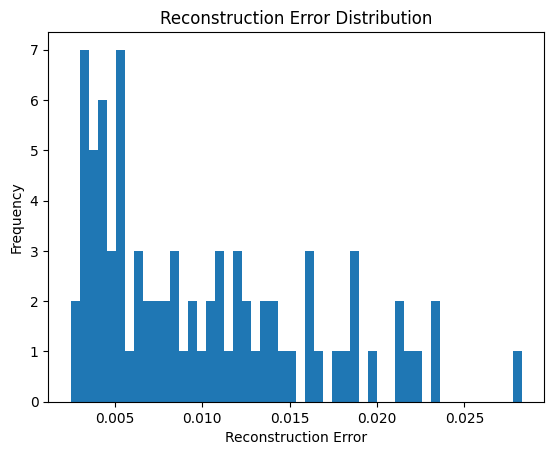

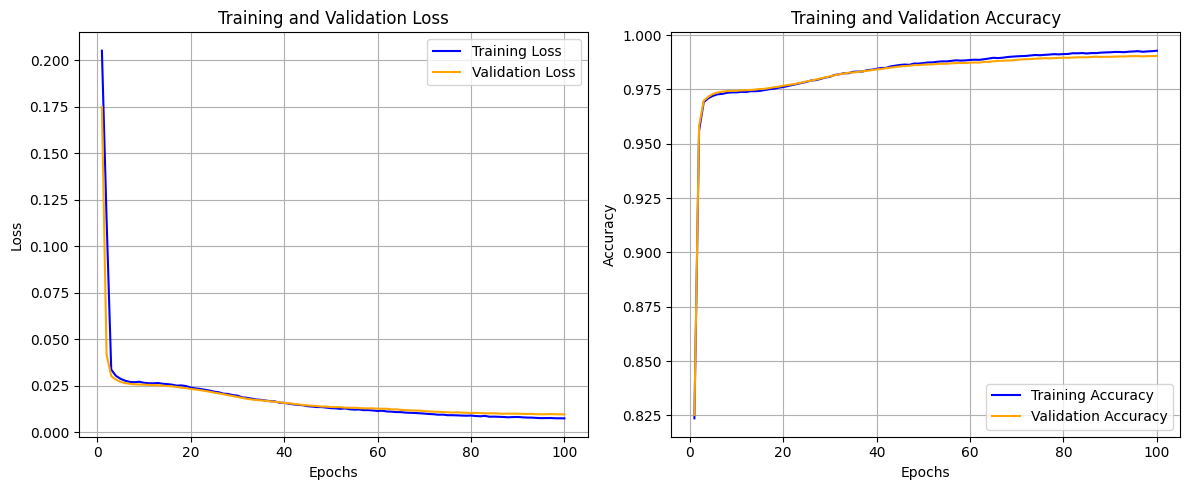

In [96]:
model.eval()
test_loss = 0
reconstruction_errors = []
predictions = []
with torch.no_grad():
    for batch in test_loader:
        # batch = batch.cuda()
        outputs = model(batch)  # Get reconstructed outputs
        loss = criterion(outputs, batch)  # Calculate loss (reconstruction error)
        test_loss += loss.item()
        
        # Calculate reconstruction errors for each sample
        errors = calculate_reconstruction_error(batch, outputs)
        reconstruction_errors.append(errors)

        # Make predictions based on a reconstruction error threshold
        threshold = 0.01  # Set your threshold for normal vs. anomalous
        preds = (errors > threshold).int()  # Predict 1 if error > threshold else 0
        predictions.append(preds)

print(f'Test Loss: {test_loss/len(test_loader)}')

# Concatenate errors and predictions
reconstruction_errors = torch.cat(reconstruction_errors)
predictions = torch.cat(predictions).numpy()

# Plot reconstruction error
plot_reconstruction_error(reconstruction_errors)
# Plot training loss and accuracy
plot_training_history(loss_history, val_loss_history, accuracy_history, val_accuracy_history)
